<a href="https://colab.research.google.com/github/parshwa1999/Map-Segmentation/blob/master/RoadMapSeg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Semantic Segmentation of Aerial Images
###Road Training

####Mounting Google Drive

In [28]:
from google.colab import drive
drive.mount('/content/gdrive/')
base_path = "gdrive/My\ Drive/MapSegClean/"
%cd gdrive/My\ Drive/MapSegClean/

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).
[Errno 2] No such file or directory: 'gdrive/My Drive/MapSegClean/'
/content/gdrive/My Drive/MapSegClean


####Importing Libraries

In [0]:
import cv2
import numpy as np
import h5py

In [0]:
import tensorflow as tf
from keras import backend as K

In [0]:
from keras.models import Model, load_model
import tensorflow as tf
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras import optimizers
from keras.layers import BatchNormalization
from tensorflow.keras.metrics import MeanIoU
import keras

from skimage import color
import pickle

####Read Data From h5 files

In [0]:
h5f = h5py.File('clean_roadlabel.h5','r')
roadlabel = h5f['clean_roadlabel'][:]
h5f.close()

h5f = h5py.File('clean_road.h5','r')
road = h5f['clean_road'][:]
h5f.close()

In [0]:
#for i in range(road.shape[0]):
#  cv2.imwrite("Road/" + str(i) + ".png", road[i])

#for i in range(roadlabel.shape[0]):
#  cv2.imwrite("RoadLabel/" + str(i) + ".png", roadlabel[i])


####Loss Function

In [0]:
def iou_coef(y_true, y_pred, smooth=1):
  intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
  union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
  iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
  return iou

def dice_coef(y_true, y_pred, smooth = 1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def soft_dice_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)


####Preprocecssing Data

In [0]:
print(roadlabel.shape)

roadlabelgray = []

for i in range(roadlabel.shape[0]):
  roadlabelgray.append(cv2.cvtColor(roadlabel[i], cv2.COLOR_BGR2GRAY))

roadlabelgray = np.asarray(roadlabelgray)
#del 

roadlabel = np.expand_dims(roadlabelgray, -1)
print(roadlabel.shape)

(22911, 256, 256, 3)
(22911, 256, 256, 1)


In [0]:
seed = 56
IMAGE_HEIGHT = IMAGE_WIDTH = 256
NUM_CHANNELS = 3

####Model

In [34]:
"""
Model
"""

inputs = Input((IMAGE_HEIGHT, IMAGE_WIDTH, 3))
s = Lambda(lambda x: x / 255) (inputs)

conv1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (inputs)
conv1 = BatchNormalization() (conv1)
conv1 = Dropout(0.1) (conv1)
conv1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv1)
conv1 = BatchNormalization() (conv1)
pooling1 = MaxPooling2D((2, 2)) (conv1)

conv2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (pooling1)
conv2 = BatchNormalization() (conv2)
conv2 = Dropout(0.1) (conv2)
conv2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv2)
conv2 = BatchNormalization() (conv2)
pooling2 = MaxPooling2D((2, 2)) (conv2)

conv3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (pooling2)
conv3 = BatchNormalization() (conv3)
conv3 = Dropout(0.2) (conv3)
conv3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv3)
conv3 = BatchNormalization() (conv3)
pooling3 = MaxPooling2D((2, 2)) (conv3)

conv4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (pooling3)
conv4 = BatchNormalization() (conv4)
conv4 = Dropout(0.2) (conv4)
conv4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv4)
conv4 = BatchNormalization() (conv4)
pooling4 = MaxPooling2D(pool_size=(2, 2)) (conv4)

conv5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (pooling4)
conv5 = BatchNormalization() (conv5)
conv5 = Dropout(0.3) (conv5)
conv5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv5)
conv5 = BatchNormalization() (conv5)


upsample6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (conv5)
upsample6 = concatenate([upsample6, conv4])
conv6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (upsample6)
conv6 = BatchNormalization() (conv6)
conv6 = Dropout(0.2) (conv6)
conv6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv6)
conv6 = BatchNormalization() (conv6)

upsample7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (conv6)
upsample7 = concatenate([upsample7, conv3])
conv7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (upsample7)
conv7 = BatchNormalization() (conv7)
conv7 = Dropout(0.2) (conv7)
conv7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv7)
conv7 = BatchNormalization() (conv7)

upsample8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (conv7)
upsample8 = concatenate([upsample8, conv2])
conv8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (upsample8)
conv8 = BatchNormalization() (conv8)
conv8 = Dropout(0.1) (conv8)
conv8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv8)
conv8 = BatchNormalization() (conv8)

upsample9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (conv8)
upsample9 = concatenate([upsample9, conv1], axis=3)
conv9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (upsample9)
conv9 = BatchNormalization() (conv9)
conv9 = Dropout(0.1) (conv9)
conv9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv9)
conv9 = BatchNormalization() (conv9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (conv9)

model = Model(inputs=[inputs], outputs=[outputs])
model.summary()


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 256, 256, 16) 448         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_19 (BatchNo (None, 256, 256, 16) 64          conv2d_20[0][0]                  
__________________________________________________________________________________________________
dropout_10 (Dropout)            (None, 256, 256, 16) 0           batch_normalization_19[0][0]     
____________________________________________________________________________________________

####Hyperparameters


In [0]:
LEARNING_RATE = 0.0001
BATCH_SIZE = 16

####Path to save Model

In [0]:
model_path = "Models/road_weights.h5"

####Callbacks

In [37]:
from tensorboardcolab import TensorBoardColab, TensorBoardColabCallback
tbc=TensorBoardColab()

Wait for 8 seconds...
TensorBoard link:
http://b2bd9d56.ngrok.io


In [0]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from datetime import datetime

checkpointer = ModelCheckpoint(model_path,
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

In [0]:
earlystopper = EarlyStopping(monitor = 'val_loss', 
                             min_delta = 0, 
                             patience = 5,
                             mode='auto',
                            restore_best_weights = True)

In [40]:
lr_reducer = ReduceLROnPlateau(monitor='val_loss',
                               factor=0.1,
                               patience=4,
                               verbose=1,
                               epsilon=1e-4)

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:1335: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


####Compile Model

In [0]:
opt = keras.optimizers.adam(LEARNING_RATE)
model.compile(
      optimizer=opt,
      loss=soft_dice_loss,
      metrics=[iou_coef])   

In [0]:
road_0 = road[0:10000]
roadlabel_0 = roadlabel[0:10000]

In [18]:
history = model.fit(road_0,
                    roadlabel_0/255,
                    validation_split = 0.1,
                    epochs=35,
                    batch_size = 16,
                    callbacks = [checkpointer, earlystopper, lr_reducer, TensorBoardColabCallback(tbc)]
                       )

with open("History/Road_History.pickle", 'wb') as f:
    pickle.dump(history, f)



Train on 9000 samples, validate on 1000 samples


Epoch 1/35
9000/9000 [==============================] - 85s 9ms/step - loss: 0.7672 - iou_coef: 0.1125 - val_loss: 0.5962 - val_iou_coef: 0.2058

Epoch 00001: val_loss improved from inf to 0.59622, saving model to Models/road_weights.h5

Epoch 2/35
9000/9000 [==============================] - 75s 8ms/step - loss: 0.6225 - iou_coef: 0.1899 - val_loss: 0.5066 - val_iou_coef: 0.2570

Epoch 00002: val_loss improved from 0.59622 to 0.50656, saving model to Models/road_weights.h5
Epoch 3/35
9000/9000 [==============================] - 75s 8ms/step - loss: 0.4953 - iou_coef: 0.2664 - val_loss: 0.4632 - val_iou_coef: 0.2830

Epoch 00003: val_loss improved from 0.50656 to 0.46322, saving model to Models/road_weights.h5
Epoch 4/35
9000/9000 [==============================] - 74s 8ms/step - loss: 0.4086 - iou_coef: 0.3260 - val_loss: 0.3895 - val_iou_coef: 0.3345

Epoch 00004: val_loss improved from 0.46322 to 0.38954, saving model to Models/roa

In [0]:
#import pickle
#with open("History/Road_History.pickle", 'rb') as f:
#    history = pickle.load(f)

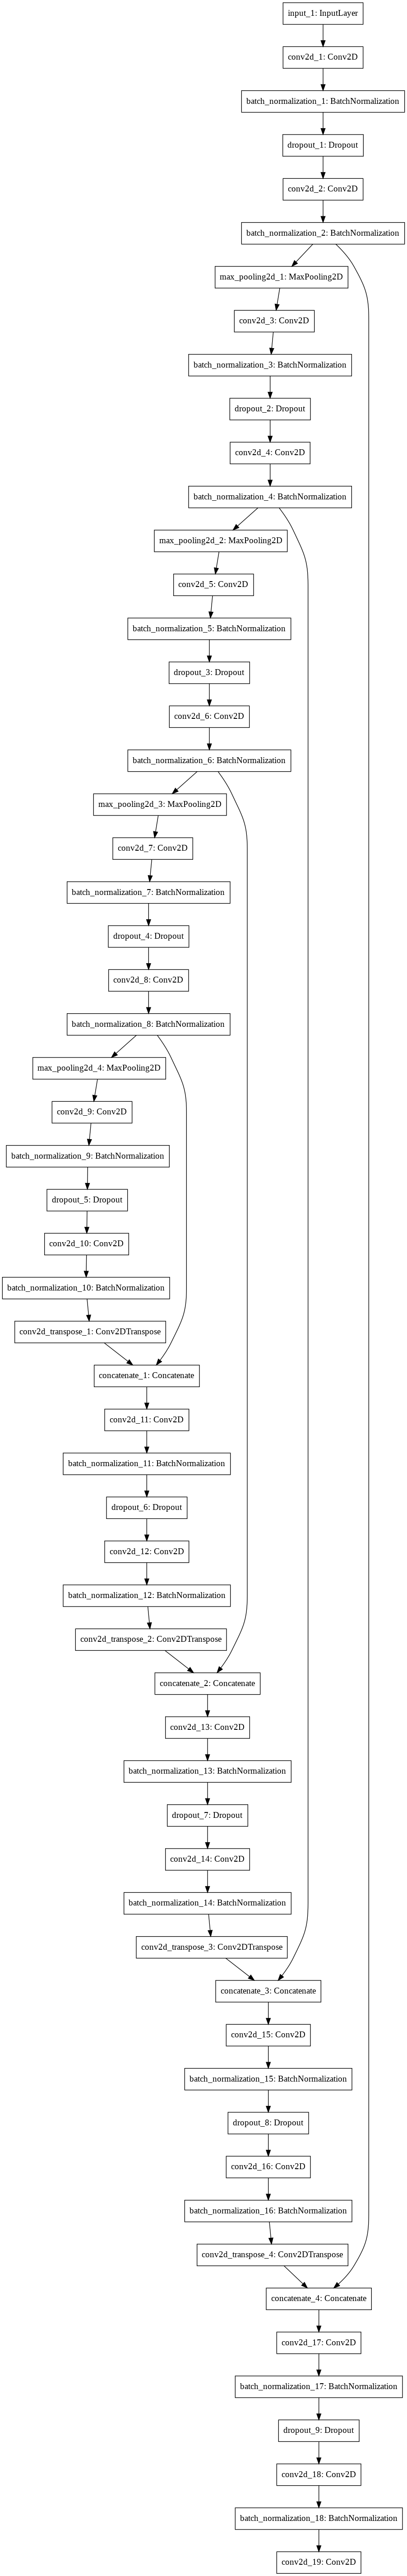

In [22]:
from keras.utils import plot_model
plot_model(model, to_file='History/road_model.png')

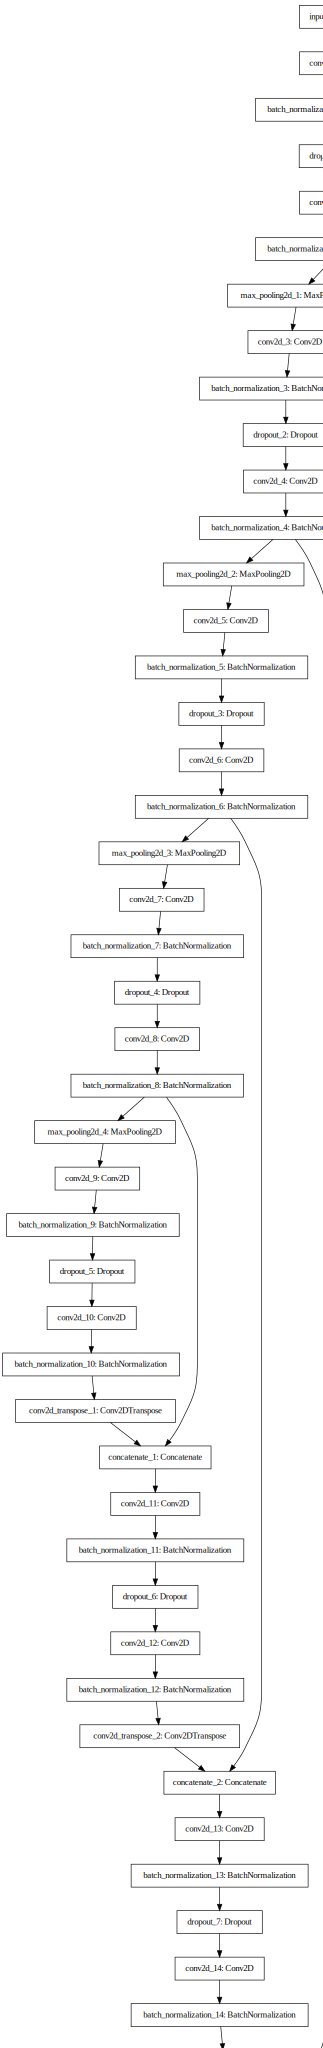

In [23]:
from IPython.display import SVG
from keras.utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

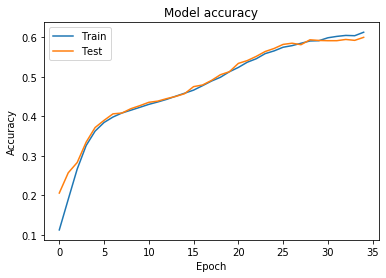

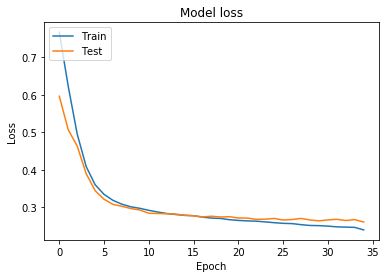

In [27]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['iou_coef'])
plt.plot(history.history['val_iou_coef'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [26]:
print(history.history.keys())

dict_keys(['val_loss', 'val_iou_coef', 'loss', 'iou_coef', 'lr'])


In [0]:
road_1 = road[10000 : len(road)]
roadlabel_1 = roadlabel[10000 : len[roadlabel]]

model.load_weights("Models/road_weights.h5")

history_1 = model.fit(road_1,
                    roadlabel_1/255,
                    validation_split = 0.1,
                    epochs=20,
                    batch_size = 32,
                    callbacks = [checkpointer, earlystopper, lr_reducer, TensorBoardColabCallback(tbc)]
                       )
#del road, roadlabel

Train on 4500 samples, validate on 500 samples
Epoch 1/100
4500/4500 [==============================] - 624s 139ms/step - loss: 0.2877 - iou_coef: 0.4938 - val_loss: 0.2783 - val_iou_coef: 0.5007

Epoch 00001: val_loss improved from 0.28103 to 0.27831, saving model to Models/colab_weights.h5
Epoch 2/100
4500/4500 [==============================] - 626s 139ms/step - loss: 0.2855 - iou_coef: 0.5002 - val_loss: 0.2729 - val_iou_coef: 0.5108

Epoch 00002: val_loss improved from 0.27831 to 0.27294, saving model to Models/colab_weights.h5
Epoch 3/100
4500/4500 [==============================] - 619s 138ms/step - loss: 0.2829 - iou_coef: 0.5073 - val_loss: 0.2711 - val_iou_coef: 0.5164

Epoch 00003: val_loss improved from 0.27294 to 0.27112, saving model to Models/colab_weights.h5
Epoch 4/100
4500/4500 [==============================] - 617s 137ms/step - loss: 0.2809 - iou_coef: 0.5152 - val_loss: 0.2736 - val_iou_coef: 0.5180

Epoch 00004: val_loss did not improve from 0.27112
Epoch 5/100
45

####Train Further

In [42]:
h5f = h5py.File('flip90_clean_roadlabel.h5','r')
roadlabel = h5f['clean_roadlabel'][:]
h5f.close()

h5f = h5py.File('flip90_clean_road.h5','r')
road = h5f['clean_road'][:]
h5f.close()

print(roadlabel.shape)

roadlabelgray = []

for i in range(roadlabel.shape[0]):
  roadlabelgray.append(cv2.cvtColor(roadlabel[i], cv2.COLOR_BGR2GRAY))

roadlabelgray = np.asarray(roadlabelgray)
#del 

roadlabel = np.expand_dims(roadlabelgray, -1)
print(roadlabel.shape)

(22911, 256, 256, 3)
(22911, 256, 256, 1)


In [0]:
del roadlabelgray

In [46]:
road_0 = road[0 : 10000]
roadlabel_0 = roadlabel[0 : 10000]

model.load_weights("Models/road_weights.h5")

history = model.fit(road_0,
                    roadlabel_0/255,
                    validation_split = 0.1,
                    epochs=20,
                    batch_size = 32,
                    callbacks = [checkpointer, earlystopper, lr_reducer, TensorBoardColabCallback(tbc)]
                       )
#del road, roadlabel

Train on 9000 samples, validate on 1000 samples
Epoch 1/20
9000/9000 [==============================] - 75s 8ms/step - loss: 0.2766 - iou_coef: 0.5835 - val_loss: 0.2677 - val_iou_coef: 0.5930

Epoch 00001: val_loss improved from inf to 0.26774, saving model to Models/road_weights.h5
Epoch 2/20
9000/9000 [==============================] - 71s 8ms/step - loss: 0.2701 - iou_coef: 0.5929 - val_loss: 0.2634 - val_iou_coef: 0.5945

Epoch 00002: val_loss improved from 0.26774 to 0.26336, saving model to Models/road_weights.h5
Epoch 3/20
9000/9000 [==============================] - 71s 8ms/step - loss: 0.2652 - iou_coef: 0.5959 - val_loss: 0.2605 - val_iou_coef: 0.6010

Epoch 00003: val_loss improved from 0.26336 to 0.26049, saving model to Models/road_weights.h5
Epoch 4/20
9000/9000 [==============================] - 71s 8ms/step - loss: 0.2635 - iou_coef: 0.6001 - val_loss: 0.2587 - val_iou_coef: 0.6043

Epoch 00004: val_loss improved from 0.26049 to 0.25866, saving model to Models/road_wei

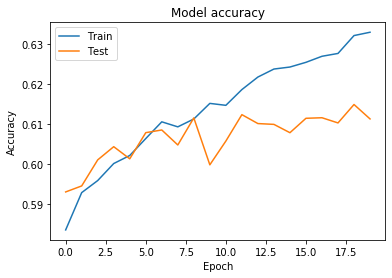

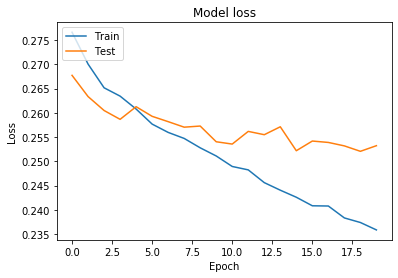

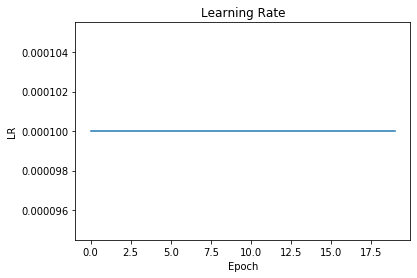

In [48]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['iou_coef'])
plt.plot(history.history['val_iou_coef'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['lr'])
#plt.plot(history.history['val_loss'])
plt.title('Learning Rate')
plt.ylabel('LR')
plt.xlabel('Epoch')
#plt.legend(['Lear', 'Test'], loc='upper left')
plt.show()


#print(history['lr'])